# 11wk: 부스팅

최규빈  
2023-11-16

# 1. Imports

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree
import sklearn.ensemble
#---#
import warnings
warnings.filterwarnings('ignore')
#---#
import matplotlib.animation
import IPython

# 2. Data

In [2]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:80]
temp.sort()
eps = np.random.randn(80)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})
df_train

# 3. 적합

In [137]:
## step1
X = df_train[['temp']]
y = df_train['sales']
## step2
boosting = sklearn.ensemble.GradientBoostingRegressor(learning_rate=0.1) 
## step3 
boosting.fit(X,y) 
## step4 -- pass 
yhat = boosting.predict(X) 

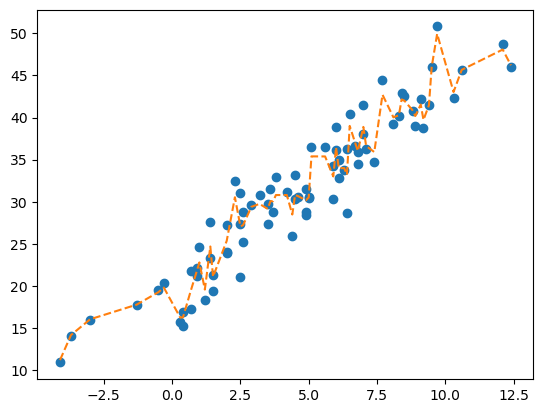

In [138]:
plt.plot(X,y,'o')
plt.plot(X,yhat,'--')

# 4. yhat을 얻는과정

In [139]:
boosting.estimators_[1][0]

In [158]:
trees = [t[0] for t in boosting.estimators_]

In [159]:
predictions = np.stack([tree.predict(X) for tree in trees])

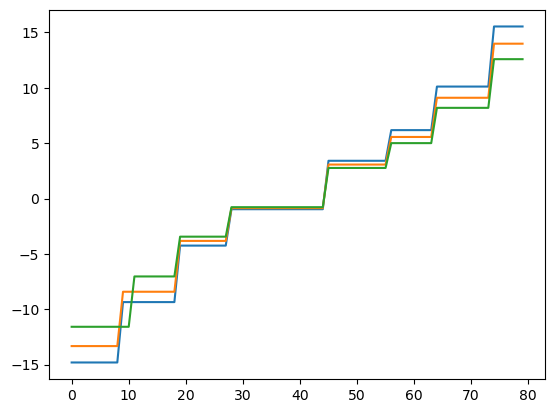

In [160]:
plt.plot(predictions[0]) # 의사결정나무0의 예측
plt.plot(predictions[1]) # 의사결정나무1의 예측
plt.plot(predictions[2]) # 의사결정나무2의 예측

In [161]:
predictions[0:2].sum(axis=0)

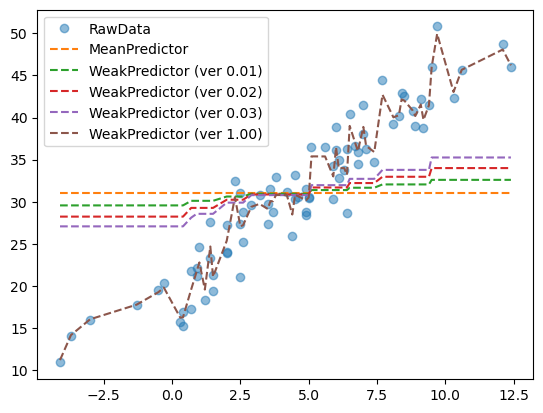

In [162]:
plt.plot(X,y,'o',alpha=0.5,label = 'RawData')
plt.plot(X,y*0+y.mean(),'--', label='MeanPredictor')
plt.plot(X,predictions[0:1].sum(axis=0)*0.1+y.mean(),'--', label='WeakPredictor (ver 0.01)')
plt.plot(X,predictions[0:2].sum(axis=0)*0.1+y.mean(),'--', label='WeakPredictor (ver 0.02)')
plt.plot(X,predictions[0:3].sum(axis=0)*0.1+y.mean(),'--', label='WeakPredictor (ver 0.03)')
plt.plot(X,predictions[:].sum(axis=0)*0.1+y.mean(),'--', label='WeakPredictor (ver 1.00)')
plt.legend()

`-` 애니메이션으로 표현해보자.

In [145]:
fig = plt.figure()

In [163]:
def func(i):
    ax = fig.gca()
    ax.clear()
    ax.plot(X,y,'o',alpha=0.5,label='RawData')
    ax.plot(X,predictions[0:i].sum(axis=0)*0.1+y.mean(),'--',label=f'WeekPredictor (ver {(i+1)/100:.2f})')
    ax.legend()

In [164]:
ani = matplotlib.animation.FuncAnimation(
    fig = fig,
    func = func,
    frames = 100
)

In [165]:
display(IPython.display.HTML(ani.to_jshtml()))

# 5. 재현

## A. 재현의 확인

`-` 아이디어: - 처음부터 `yhat`을 강하게 학습하지 말고 약하게 조금씩
학습하자. - 그리고 부족한 부분(= 학습이 안된 부분 = y-yhat)을 조금씩
강화시키며 보완하자.

In [300]:
trees_manual = []
predictions_manaul = []
residuals_manual = []

In [301]:
res = y - y.mean()
for i in range(100):    
    tree = sklearn.tree.DecisionTreeRegressor(
        criterion='friedman_mse',
        max_depth=3
    )
    tree.fit(X,res)
    yhat = tree.predict(X) # 한번에 다 학습하지 말고 일단 0.1만큼만 학습하자. 0.1은 "학습률" 
    res = res - yhat*0.1
    trees_manual.append(tree) 
    predictions_manaul.append(yhat)
    residuals_manual.append(res)

In [302]:
predictions_manaul = np.stack(predictions_manaul)
residuals_manual = np.stack(residuals_manual)

`-` 비교

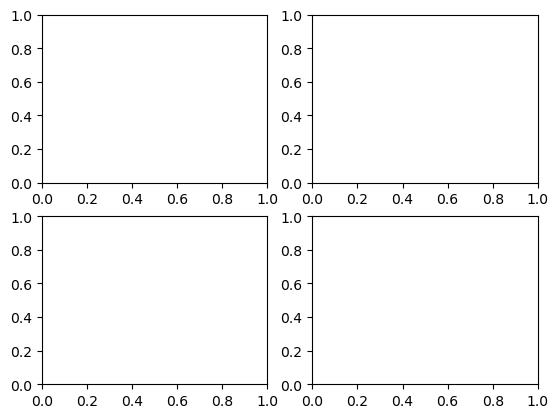

In [362]:
fig,ax = plt.subplots(2,2)

In [363]:
def func(i):
    ax[0][0].clear();
    ax[0][0].plot(X,y,'o',alpha=0.5)
    ax[0][0].plot(X,predictions[0:i].sum(axis=0)*0.1+y.mean(),'--')
    ax[0][1].clear();
    ax[0][1].plot(X,y,'o',alpha=0.5)
    ax[0][1].plot(X,predictions_manaul[0:i].sum(axis=0)*0.1+y.mean(),'--')
    #--#
    sklearn.tree.plot_tree(trees[i],max_depth=0,ax=ax[1][0])
    sklearn.tree.plot_tree(trees_manual[i],max_depth=0,ax=ax[1][1])

In [364]:
ani = matplotlib.animation.FuncAnimation(
    fig,
    func,
    frames = 20
)

In [365]:
display(IPython.display.HTML(ani.to_jshtml()))

## B. Step별 분석

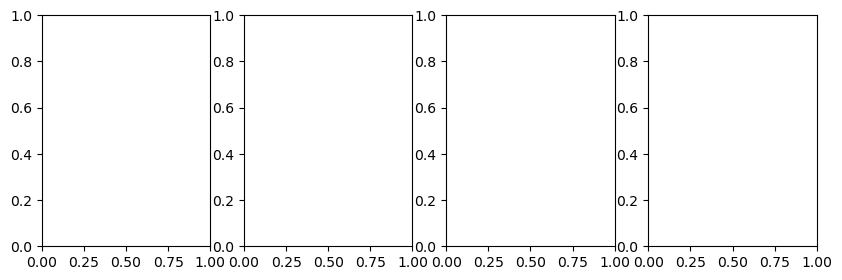

In [331]:
fig,ax = plt.subplots(1,4,figsize=(10,3))

In [358]:
def func(i):
    ax[0].clear();
    ax[0].plot(X,y,'o',alpha=0.5)
    ax[0].plot(X,predictions[0:i].sum(axis=0)*0.1+y.mean(),'--')
    ax[0].set_title("Step0")
    ax[1].clear();
    ax[1].set_ylim(-20,20)
    ax[1].plot(X,residuals_manual[i],'o',alpha=0.5)
    ax[1].set_title("Step1:Residual")
    ax[2].clear();
    ax[2].set_ylim(-20,20)
    ax[2].plot(X,residuals_manual[i],'o',alpha=0.5)
    ax[2].plot(X,predictions[i],'--')
    ax[2].set_title("Step2:Fit")
    ax[3].clear();
    ax[3].plot(X,y,'o',alpha=0.5)
    ax[3].plot(X,predictions[:i].sum(axis=0)*0.1+y.mean(),'--',color='C1')
    ax[3].plot(X,predictions[:(i+1)].sum(axis=0)*0.1+y.mean(),'--',color='C3')
    ax[3].set_title("Step3:Update")        

In [359]:
ani = matplotlib.animation.FuncAnimation(
    fig,
    func,
    frames = 20
)

In [360]:
display(IPython.display.HTML(ani.to_jshtml()))

-   관찰1: “Step1: Residual”은 점점 단순오차차럼 변화한다.
-   관찰2: “Step2: Fit”의 분기점들은 고정된 값이 아니다. (계속 변한다)
-   관찰3: “Step3: Update” 업데이터되는 양은 반복이 진행될수록 점점
    작아진다.

`-` 위의 그림에서

-   Step0: 공부할 자료, 현재까지 공부량
-   Step1: 남은 공부량
-   Step2: 공부! (이해O / 암기X)
-   Step3: 공부의 10%의 기억.. 기억나는 것만 두뇌에 update되어있음.

`-` 느낌: 조금씩 데이터를 학습한다. 학습할 자료가 오차항처럼 보인다면?
그때는 적합을 멈춘다. (오차항을 적합할 필요는 없잖아?)

# 6. 왜 이렇게 만들었을까?

`-` 만든 사람 마음이라 저도 잘 모르겠네요.

-   이런류의 방법은 “해보니까 되더라”라는 논리

`-` 만든사람에게 빙의해서 생각한다면? (이런 모티브이지 않았을까?)

-   의사결정나무는 선형모형의 여러 단점들을 해결할 수 있는 아주 우수한
    방법이야.
-   그렇지만 오버핏을 유발하는 단점이 있어.
-   오버핏을 방지하기 위해서 개발된 여러가지 방법들이 있는데, 나만의
    새로운 방법을 개발하고 싶어.
-   우선 오버핏을 방지하기 위해서 아주 약한 학습기를 만들자.
-   언더핏을 방지하기 위해서 약한 학습기를 성장시키자!

> 랜덤포레스트는 약한학습기들이 모여서 강한학습기로 작용한다 (팀플레이
> 느낌). 부스팅은 최초의 약한 학습기가 점점 강한 학습기로 진화한다 (만화
> 주인공).